In [1]:
!nvidia-smi

Sat Feb 15 20:30:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX150       On   | 00000000:01:00.0 Off |                  N/A |
| N/A   32C    P8    N/A /  N/A |    561MiB /  2002MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import torch
import torchvision
from torchvision import transforms
import random
import numpy as np
import matplotlib.pyplot as plt

In [25]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [26]:
class MyNet(torch.nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.act1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=16)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.act2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=32)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.act3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=64)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.act4 = torch.nn.LeakyReLU()
        self.bn4 = torch.nn.BatchNorm2d(num_features=128)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=3, stride=3)

        self.fc1 = torch.nn.Linear(128, 80)
        self.act5 = torch.nn.LeakyReLU()
        self.dropout1 = torch.nn.Dropout(0.5)

        self.fc2 = torch.nn.Linear(80, 80)
        self.act6 = torch.nn.LeakyReLU()
        self.dropout2 = torch.nn.Dropout(0.5)

        self.fc3 = torch.nn.Linear(80, 80)
        self.act7 = torch.nn.Tanh()
        self.dropout3 = torch.nn.Dropout(0.5)     

        self.fc4 = torch.nn.Linear(80, 10)
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.bn2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.bn3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.act4(x)
        x = self.bn4(x)
        x = self.pool4(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act5(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.act6(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.act7(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        
        return x

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = torch.load('/home/matvey/Morozov/Научрук/Диплом/Модель/CIFAR10_net.pth')
net.eval()

MyNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): LeakyReLU(negative_slope=0.01)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, trac

In [28]:
test_tf = transforms.Compose([
    transforms.ToTensor()
])

test = torchvision.datasets.CIFAR10('Модель/', download=False, train=False, transform=test_tf)
testloader = torch.utils.data.DataLoader(dataset=test, batch_size=256, shuffle=False)

### SimBA

In [29]:
import utils

In [40]:
def normalize(x):
    return utils.apply_normalization(x, 'cifar')

def get_probs(model, x, y):
    output = model(normalize(x.cuda())).cpu()
    probs = torch.nn.Softmax()(output)[:, y]
    return torch.diag(probs.data)

# 20-line implementation of (untargeted) SimBA for single image input
def simba_single(model, x, y, num_iters=10000, epsilon=0.2):
    n_dims = x.view(1, -1).size(1)
    perm = torch.randperm(n_dims)
    last_prob = get_probs(model, x, y)
    for i in range(num_iters):
        diff = torch.zeros(n_dims)
        diff[torch.randint(0, 32*32, (1,))[0]] = epsilon     
        left_prob = get_probs(model, (x - diff.view(x.size()).to(device)).clamp(0, 1), y)
        if left_prob < last_prob:
            x = (x - diff.view(x.size()).to(device)).clamp(0, 1)
            last_prob = left_prob
        else:
            right_prob = get_probs(model, (x + diff.view(x.size()).to(device)).clamp(0, 1), y)
            if right_prob < last_prob:
                x = (x + diff.view(x.size()).to(device)).clamp(0, 1)
                last_prob = right_prob
    return x

In [41]:
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)

In [42]:
from scipy.special import softmax

### Все классы кроме 1

/home/matvey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/home/matvey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


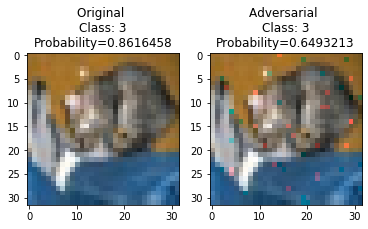

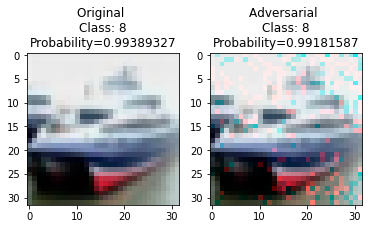

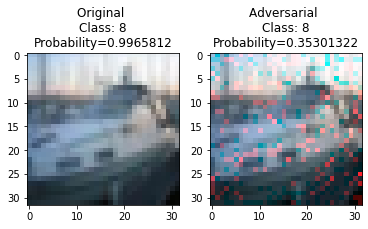

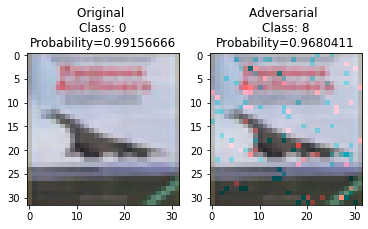

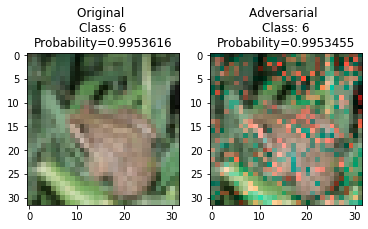

In [53]:
for i in range(5):
    example = example_data[i]
    prob_original = softmax(net(example.reshape(1,3,32,32).to(device)).data.cpu().numpy()[0])

    x = simba_single(net, example_data[i].reshape(1, 3,32,32).to(device), torch.tensor(example_targets[i]).to(device), num_iters=2000, epsilon=0.3)

    prob_adv = softmax(net(x.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])

    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(example.data.cpu().numpy().transpose((1,2,0)))
    axes[0].set_title('Original ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_original)) + '\n'
                      + 'Probability=' + str(np.max(prob_original)))
    axes[1].imshow(x.data.cpu().numpy()[0].transpose((1,2,0)))
    axes[1].set_title('Adversarial ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_adv)) + '\n'
                      + 'Probability=' + str(np.max(prob_adv)))

    plt.show()

## Fast gradient sign method

In [54]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [58]:
loss = torch.nn.CrossEntropyLoss()
example_data, example_targets = example_data.to(device), example_targets.to(device)
example_data.requires_grad = True
output = net(example_data)

loss_val = loss(output, example_targets)

net.zero_grad()
loss_val.backward()

data_grad = example_data.grad.data

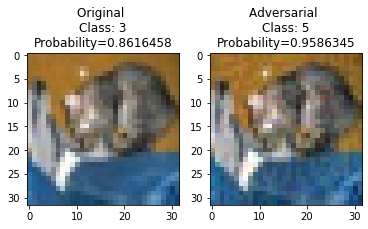

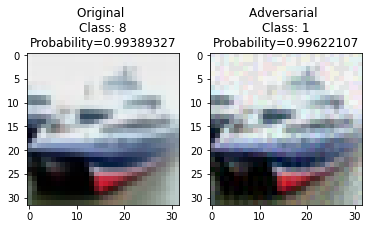

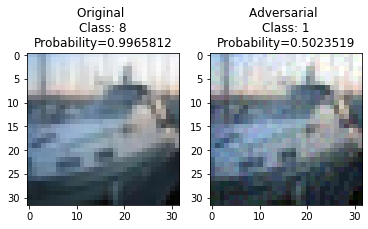

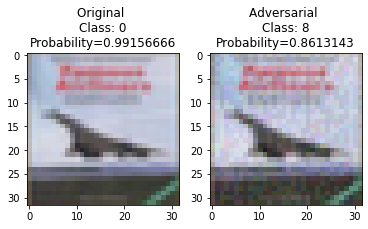

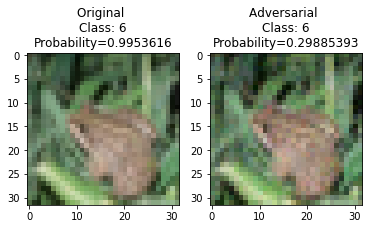

In [62]:
for i in range(5):
    example = example_data[i]
    prob_original = softmax(net(example.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])

    x = fgsm_attack(example_data[i], 0.03, data_grad[i])
    prob_adv = softmax(net(x.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])

    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(example.data.cpu().numpy().transpose((1,2,0)), cmap='gray')
    axes[0].set_title('Original ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_original)) + '\n'
                      + 'Probability=' + str(np.max(prob_original)))

    axes[1].imshow(x.data.cpu().numpy().transpose((1,2,0)), cmap='gray')
    axes[1].set_title('Adversarial ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_adv)) + '\n'
                      + 'Probability=' + str(np.max(prob_adv)))

    plt.show()

## Iterative Fast gradient sign method.

In [69]:
torch.retain_graph=True
loss_val = loss(output, example_targets)

In [70]:
def ifgsm_attack(example_data, example_targets, net, loss, epsilon, iteration=1):
    example_data_copy = example_data
    
    for i in range(iteration):
        output = net(example_data)
        loss_val = loss(output, example_targets)

        net.zero_grad()
        loss_val.backward()
        data_grad = example_data.grad.data
        sign_data_grad = data_grad.sign()
        perturbed_images = example_data + epsilon*sign_data_grad
        perturbed_images = torch.clamp(perturbed_images, 0, 1)     
        example_data = torch.tensor(perturbed_images, requires_grad=True) 
        
    example_data = example_data_copy
        
    return perturbed_images

In [71]:
retain_graph=True
perturbed_images = ifgsm_attack(example_data, example_targets, net, loss, 0.01, iteration=3)

/home/matvey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


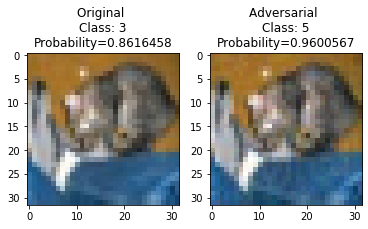

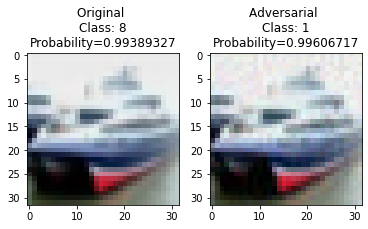

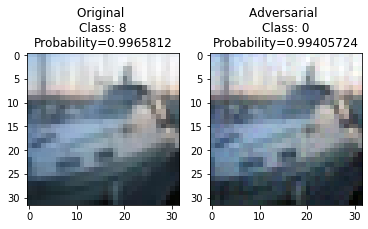

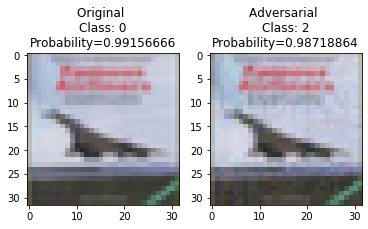

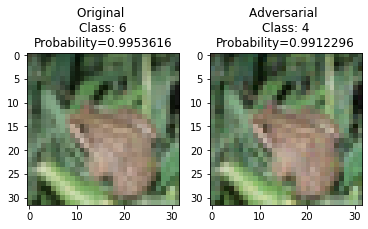

In [80]:
for i in range(5):
    if (example_targets[i]).cpu().numpy() != 1:
        example = example_data[i]
        prob_original = softmax(net(example.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])
        x = perturbed_images[i]
        prob_adv = softmax(net(x.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])

        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(example.data.cpu().numpy().transpose((1,2,0)))
        axes[0].set_title('Original ' + '\n'
                          + 'Class: '+ str(np.argmax(prob_original)) + '\n'
                          + 'Probability=' + str(np.max(prob_original)))

        axes[1].imshow(x.data.cpu().numpy().transpose((1,2,0)))
        axes[1].set_title('Adversarial ' + '\n'
                          + 'Class: '+ str(np.argmax(prob_adv)) + '\n'
                          + 'Probability=' + str(np.max(prob_adv)))

        plt.show()

### Our method

In [81]:
from numpy.linalg import norm

In [82]:
train = torchvision.datasets.CIFAR10('Модель/', download=False, train=True, transform=test_tf)
trainloader = torch.utils.data.DataLoader(dataset=train, batch_size=10000, shuffle=False)

In [83]:
examples_train = enumerate(trainloader)
batch_idx, (train_data, train_targets) = next(examples)

In [84]:
train_data = train_data.to(device)
train_targets = train_targets.to(device)

In [102]:
def nearest_image(image, label, train_data, train_targets):
    image = image.data.cpu().numpy()[0]
    all_norm = []
    for i, train_image in enumerate(train_data):
        if train_targets[i].data.cpu().numpy() != label:
            train_image = train_image.data.cpu().numpy()
            diff = train_image - image
            norm_diff = norm(diff)
            all_norm.append(norm_diff)
        else:
            all_norm.append(1e20)            

    index = np.argmin(all_norm)
    return index

def out_attack(image, label, train_data, train_targets, eps):
    index = nearest_image(image, label, train_data, train_targets)
    res = (1.-eps) * image + eps * (train_data[index] - image)
    return res.clamp(0, 255)

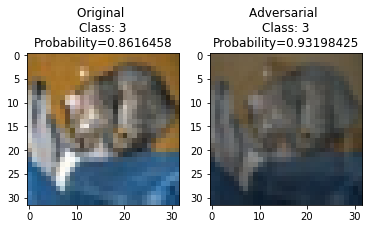

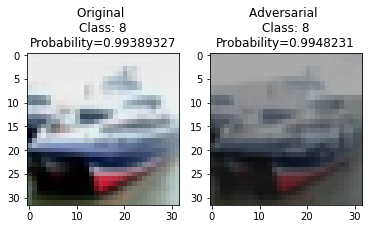

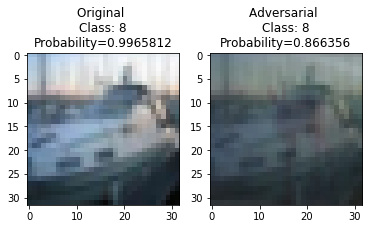

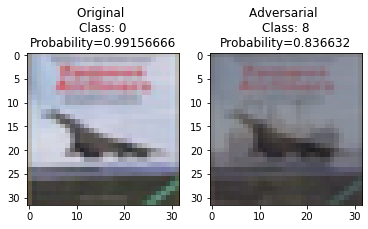

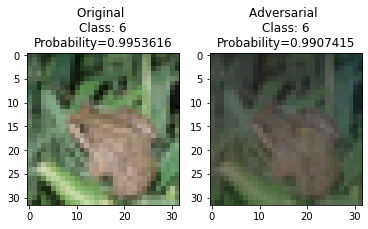

In [105]:
for i in range(5):
    example = example_data[i]
    prob_original = softmax(net(example.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])        
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(example.data.cpu().numpy().transpose((1,2,0)))
    axes[0].set_title('Original ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_original)) + '\n'
                      + 'Probability=' + str(np.max(prob_original)))
    x = out_attack(example, example_targets[i].data.cpu().numpy(), train_data, train_targets, 0.3)
    prob_adv = softmax(net(x.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])

    axes[1].imshow(x.data.cpu().numpy().transpose((1,2,0)))
    axes[1].set_title('Adversarial ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_adv)) + '\n'
                      + 'Probability=' + str(np.max(prob_adv)))

    plt.show()